In [1]:
import sys
from pathlib import Path

# Get the current working directory and go up one level
parent_dir = Path.cwd().parent
sys.path.append(str(parent_dir))


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

import mlflow
mlflow.set_experiment("kaggle-playground-5-8")

<Experiment: artifact_location='file:///c:/Users/olive/desktop/projects/kaggle/kaggle_playground_5-8/new_fortransformers/mlruns/435223158587620822', creation_time=1755273647363, experiment_id='435223158587620822', last_update_time=1755273647363, lifecycle_stage='active', name='kaggle-playground-5-8', tags={}>

In [24]:
train = pd.read_csv("../train.csv")
test = pd.read_csv("../test.csv")
original = pd.read_csv("../bank-full.csv", sep=";")
original['y'] = original['y'].map({'yes': 1, 'no': 0})

In [25]:
original.shape

(45211, 17)

In [4]:
categorical_features = train.select_dtypes(include=["object"]).columns
numerical_features = list(set(train.select_dtypes(include=["int64", "float64"]).columns) - {"y", "id"})

In [7]:
train[train['pdays'] == -1].shape

(672434, 18)

<Axes: xlabel='pdays', ylabel='Count'>

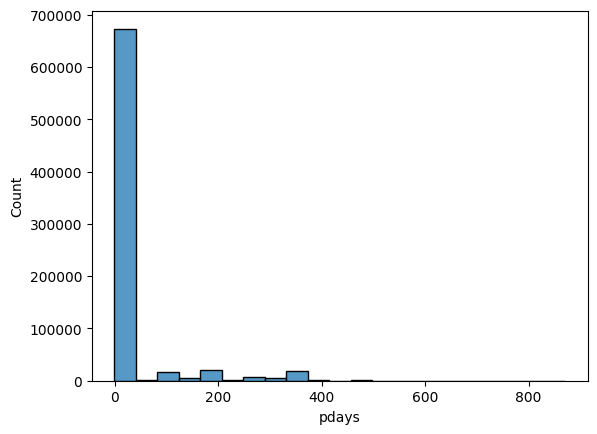

In [8]:
sns.histplot(data=train, x = "pdays")

In [7]:
original

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [30]:
original.select_dtypes(include=["object"])

,job,marital,education,default,housing,loan,contact,month,poutcome
0,management,married,tertiary,no,yes,no,unknown,may,unknown
1,technician,single,secondary,no,yes,no,unknown,may,unknown
2,entrepreneur,married,secondary,no,yes,yes,unknown,may,unknown
3,blue-collar,married,unknown,no,yes,no,unknown,may,unknown
4,unknown,single,unknown,no,no,no,unknown,may,unknown
...,...,...,...,...,...,...,...,...,...
45206,technician,married,tertiary,no,no,no,cellular,nov,unknown
45207,retired,divorced,primary,no,no,no,cellular,nov,unknown
45208,retired,married,secondary,no,no,no,cellular,nov,success
45209,blue-collar,married,secondary,no,no,no,telephone,nov,unknown


In [51]:
from typing import Literal
from sklearn.base import BaseEstimator, TransformerMixin

class NoPdaysTransformer(BaseEstimator, TransformerMixin):

    def  __init__(self):
        return
    
    def fit(self, X, y=None):
        # dont need to learn anything
        return self
    
    def set_output(self, *, transform=None):
        # we just store the preference; we already return a DataFrame anyway
        self._output = transform
        return self
    
    def transform(self, X):
        # if pdays is -1, create new column and set it to 1
        X_new = X.copy()
        X_new['no_pdays'] = (X_new['pdays'] == -1).astype(int)
        return X_new



class RareCatEncoder(BaseEstimator, TransformerMixin):
    ## for categorical features, one hot encode majority classes, rare categories get their own column
    ## default pandas output dataframe

    def __init__(self, rare_fraction_scale=0.4, rare_threshold_net=0.03):
        self.rare_fraction_scale = rare_fraction_scale
        self.rare_threshold_net = rare_threshold_net

    def set_output(self, *, transform=None):
        self._output = transform
        return self

    def fit(self, X, y=None):
        ## record columns, particularly ones that are rare or not
        self.feature_names_in_ = list(X.columns)
        self.rare_map_ = {}
        self.encode_map_ = {}
        self.encoders_ = {}

        for col in X.columns:
            vs = X[col].value_counts(normalize=True)
            expected = 1 / X[col].nunique()

            threshold = max(self.rare_threshold_net, self.rare_fraction_scale*expected)
            rare_cols = vs[vs < threshold].index.tolist()
            encode_cols = vs[vs >= threshold].index.tolist()

            if not encode_cols:
                encode_cols = [vs.idxmax()]

            self.rare_map_[col] = rare_cols
            self.encode_map_[col] = encode_cols

            # store encoder to be used later
            enc = OneHotEncoder(
                handle_unknown="ignore",
                sparse_output=False,
                categories=[encode_cols]
            )
            enc.set_output(transform="pandas")
            enc.fit(X[[col]])
            self.encoders_[col] = enc

        return self


    def transform(self, X):

        X_new = X.copy()
        frames = []

        for col in self.feature_names_in_: # iterate over columns

            # get rare and regular columns
            rare_cols = self.rare_map_[col]
            encode_cols = self.encode_map_[col]

            # group rare columns in a single column
            rare_or_unknown = ~X_new[col].isin(self.encode_map_[col])
            rare_col = rare_or_unknown.map({True: 1, False: 0}).to_frame(f"{col}_rare")
            
            # use one hot encoding for regular columns
            enc = self.encoders_[col]
            enc_df = enc.transform(X_new[[col]])

            frames.append(pd.concat([rare_col, enc_df], axis=1))
        

        ret_df = pd.concat(frames, axis=1)

        return ret_df


class TargetEncodeWithOriginal(BaseEstimator, TransformerMixin):

    def __init__(self, original_path):
        self.original_path = original_path

    def set_output(self, *, transform=None):
        self._output = transform
        return self
    
    def get_feature_names_out(self, input_features=None):
        cols = input_features if input_features is not None else getattr(self, "feature_names_in_", None)
        return np.array([f"{col}_target_encoded" for col in cols], dtype=object)
    
    def fit(self, X, y=None):
        ## learn the targets off the original dataset

        original = pd.read_csv(self.original_path, sep=";")
        print("original: ", original.shape)
        original['y'] = original['y'].map({'yes': 1, 'no': 0})
        self.y_all_mean_ = original['y'].mean()
        categorical_cols = original.select_dtypes(include=["object"]).columns

        self.mapping_ = {}  # save as column: (series of target means)
        self.feature_names_in_ = [col for col in X.columns if col in categorical_cols]

        for col in self.feature_names_in_:

            stats = original.groupby(col)["y"].agg(["size","mean"])
            self.mapping_[col] = stats["mean"]

        return self
    
    def transform(self, X):

        frames = []

        for col in self.feature_names_in_:

            column = X[col]
            series = self.mapping_[col]

            target_encode = column.map(series)
            target_encode = target_encode.fillna(self.y_all_mean_)

            frames.append(target_encode.to_frame(f"{col}_target_encoded"))

        return pd.concat(frames, axis=1)



class PdaysFeatureEngineer(BaseEstimator, TransformerMixin):
    """
    Feature engineering for pdays column: handle missing values and create temporal bins.
    """
    def __init__(self, create_bins=True):
        self.create_bins = create_bins
        
    def fit(self, X, y=None):
        return self
    
    def set_output(self, *, transform=None):
        self._output = transform
        return self
    
    def transform(self, X):
        X_df = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X.copy()
        
        if 'pdays' in X_df.columns:
            # Create indicator for missing pdays
            X_df['pdays_none'] = (X_df['pdays'] == -1).astype(int)
            
            # Replace -1 with NaN
            X_df['pdays'] = X_df['pdays'].replace(-1, np.nan)
            
            if self.create_bins:
                # Create temporal bins as in your pipeline
                X_df['pdays_qtr_yr'] = ((X_df['pdays'] > 84) & (X_df['pdays'] < 96)).astype(int)
                X_df['pdays_hlf_yr'] = ((X_df['pdays'] > 175) & (X_df['pdays'] < 190)).astype(int)
                X_df['pdays_fl_yr'] = ((X_df['pdays'] > 359) & (X_df['pdays'] < 372)).astype(int)
                X_df['pdays_mor_yr'] = (X_df['pdays'] > 371).astype(int)
            
        return X_df

In [52]:
categorical_features = train.select_dtypes(include=["object"]).columns
numerical_features = list(set(train.select_dtypes(include=["int64", "float64"]).columns) - {"y", "id", "pdays"})

preprocessor = ColumnTransformer(
    transformers = [
        ("te_original", TargetEncodeWithOriginal("../bank-full.csv"), categorical_features),
        ("cat", RareCatEncoder(rare_fraction_scale=0.4, rare_threshold_net=0.03), categorical_features),
        ("no_pdays", NoPdaysTransformer(), ["pdays"]),
        ("pdays_qtr_yr", PdaysFeatureEngineer(), ["pdays"]),
    ],
    remainder = "passthrough")

preprocessor.set_output(transform="pandas")

ColumnTransformer(remainder='passthrough',
                  transformers=[('te_original',
                                 TargetEncodeWithOriginal(original_path='../bank-full.csv'),
                                 Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome'],
      dtype='object')),
                                ('cat', RareCatEncoder(),
                                 Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome'],
      dtype='object')),
                                ('no_pdays', NoPdaysTransformer(), ['pdays']),
                                ('pdays_qtr_yr', PdaysFeatureEngineer(),
                                 ['pdays'])])

In [53]:
preprocessor.fit(train)

original:  (45211, 17)


c:\Users\olive\miniconda3\Lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


ColumnTransformer(remainder='passthrough',
                  transformers=[('te_original',
                                 TargetEncodeWithOriginal(original_path='../bank-full.csv'),
                                 Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome'],
      dtype='object')),
                                ('cat', RareCatEncoder(),
                                 Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome'],
      dtype='object')),
                                ('no_pdays', NoPdaysTransformer(), ['pdays']),
                                ('pdays_qtr_yr', PdaysFeatureEngineer(),
                                 ['pdays'])])

In [54]:
train_transformed = preprocessor.fit_transform(train)

original:  (45211, 17)


In [64]:
train_transformed.columns

Index(['te_original__job_target_encoded',
       'te_original__marital_target_encoded',
       'te_original__education_target_encoded',
       'te_original__default_target_encoded',
       'te_original__housing_target_encoded',
       'te_original__loan_target_encoded',
       'te_original__contact_target_encoded',
       'te_original__month_target_encoded',
       'te_original__poutcome_target_encoded', 'cat__job_rare',
       'cat__job_management', 'cat__job_blue-collar', 'cat__job_technician',
       'cat__job_admin.', 'cat__job_services', 'cat__job_retired',
       'cat__marital_rare', 'cat__marital_married', 'cat__marital_single',
       'cat__education_rare', 'cat__education_secondary',
       'cat__education_tertiary', 'cat__education_primary',
       'cat__default_rare', 'cat__default_no', 'cat__housing_rare',
       'cat__housing_yes', 'cat__housing_no', 'cat__loan_rare', 'cat__loan_no',
       'cat__contact_rare', 'cat__contact_cellular', 'cat__contact_unknown',
       'cat__

In [56]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
import numpy as np

x_train = train_transformed.drop(columns=["remainder__y", "remainder__id"])
y_train = train_transformed["remainder__y"]

def objective(trial):
    params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "verbosity": 0,
        "max_depth": trial.suggest_int("max_depth", 2, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.5),
        "n_estimators": trial.suggest_int("n_estimators", 300, 2000),
        "subsample": trial.suggest_float("subsample", 0.01, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.01, 1.0),
        "gamma": trial.suggest_float("gamma", 0.01, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 1.0),
        "random_state": 42,
        "seed": 42,
    }

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    aucs = []

    for train_idx, valid_idx in cv.split(x_train, y_train):
        X_train_cv, X_valid_cv = x_train.iloc[train_idx], x_train.iloc[valid_idx]
        y_train_cv, y_valid_cv = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        model = XGBClassifier(**params)
        model.fit(X_train_cv, y_train_cv)

        preds = model.predict_proba(X_valid_cv)[:, 1]
        auc = roc_auc_score(y_valid_cv, preds)
        aucs.append(auc)

    return np.mean(aucs)


In [57]:
import optuna

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=12)

print("Best AUC:", study.best_value)
print("Best Params:", study.best_params)


[I 2025-08-18 22:36:53,838] A new study created in memory with name: no-name-ccd63bcd-54d2-4805-939d-b3a17f0f9ff0
[I 2025-08-18 22:40:25,868] Trial 0 finished with value: 0.9636847723373427 and parameters: {'max_depth': 5, 'learning_rate': 0.476219528871998, 'n_estimators': 1632, 'subsample': 0.653088068627625, 'colsample_bytree': 0.26959754883688175, 'gamma': 0.9008867862757011, 'reg_alpha': 0.8570988976006143, 'reg_lambda': 0.2586090561857897}. Best is trial 0 with value: 0.9636847723373427.
[I 2025-08-18 22:42:23,028] Trial 1 finished with value: 0.9664480154949412 and parameters: {'max_depth': 9, 'learning_rate': 0.11647963041710589, 'n_estimators': 489, 'subsample': 0.5802207918046272, 'colsample_bytree': 0.6680167607390952, 'gamma': 0.3299521527492995, 'reg_alpha': 0.8365848185040969, 'reg_lambda': 0.29047332828168765}. Best is trial 1 with value: 0.9664480154949412.
[I 2025-08-18 22:45:40,355] Trial 2 finished with value: 0.9516346721199639 and parameters: {'max_depth': 11, 'lea

Best AUC: 0.967488199794059
Best Params: {'max_depth': 10, 'learning_rate': 0.01652644342965019, 'n_estimators': 1723, 'subsample': 0.26051833377326056, 'colsample_bytree': 0.938632653087855, 'gamma': 0.8315864314316477, 'reg_alpha': 0.5323148301039287, 'reg_lambda': 0.779066731886579}


In [41]:
study.best_params

{'max_depth': 4,
 'learning_rate': 0.09980390197188291,
 'n_estimators': 1729,
 'subsample': 0.8291246065651641,
 'colsample_bytree': 0.7777451533658114,
 'gamma': 0.8127135235627548,
 'reg_alpha': 0.6624892508132036,
 'reg_lambda': 0.9872076931311231}

In [59]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score  # use the right metric for your task

# Example: binary classification
X = train_transformed.drop(columns=["remainder__y", "remainder__id"]).values
y = train_transformed["remainder__y"].values

model = XGBClassifier(**study.best_params)

n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

oof_preds = np.zeros(len(X))  # to store out-of-fold predictions
scores = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X, y), 1):
    X_train, X_valid = X[train_idx], X[valid_idx]
    y_train, y_valid = y[train_idx], y[valid_idx]

    model.fit(X_train, y_train)
    
    preds = model.predict_proba(X_valid)[:, 1]  # probability for positive class
    oof_preds[valid_idx] = preds
    
    score = roc_auc_score(y_valid, preds)
    scores.append(score)
    
    print(f"Fold {fold} AUC: {score:.4f}")

mean_score = np.mean(scores)
print(f"Mean AUC: {mean_score:.4f}")

# OOF predictions now in oof_preds

Fold 1 AUC: 0.9686
Fold 2 AUC: 0.9672
Fold 3 AUC: 0.9673
Fold 4 AUC: 0.9683
Fold 5 AUC: 0.9678
Mean AUC: 0.9678


In [60]:
test['y'] = 0

In [61]:
test_transformed = preprocessor.transform(test)

In [62]:
test_id = test["id"]
test_ready = test_transformed.drop(columns=["remainder__y", "remainder__id"])

probas = model.predict_proba(test_ready)[:, 1]

submission = pd.DataFrame({"id": test_id, "y": probas})
submission.to_csv("submission.csv", index=False)

In [58]:
study.best_params

{'max_depth': 10,
 'learning_rate': 0.01652644342965019,
 'n_estimators': 1723,
 'subsample': 0.26051833377326056,
 'colsample_bytree': 0.938632653087855,
 'gamma': 0.8315864314316477,
 'reg_alpha': 0.5323148301039287,
 'reg_lambda': 0.779066731886579}

In [65]:
with mlflow.start_run(run_name="te_extradata"):
    mlflow.log_params({
        "model": "xgboost",
        "max_depth": 10,
        "learning_rate": 0.01652644342965019,
        "n_estimators": 1723,
        "subsample": 0.26051833377326056,
        "colsample_bytree": 0.938632653087855,
        "gamma": 0.8315864314316477,
        "reg_alpha": 0.5323148301039287,
        "reg_lambda": 0.779066731886579
    })

    mlflow.set_tag(
    "mlflow.note.content",
    "Simple xgb model, 12 runs on optuna, with wider search space.\n"
    "Key change: added features for pdays, ie whether its quarter year, half year etc. I think this model has potential but perhaps needs more trials on optuna.\n"
    "Pipeline:\n"
    "(pdays_qtr_yr, PdaysFeatureEngineer(), ['pdays']),\n"
    "(te_original, TargetEncodeWithOriginal('../bank-full.csv'), categorical_features),\n"
    "(cat, RareCatEncoder(rare_fraction_scale=0.4, rare_threshold_net=0.03), categorical_features),\n"
    "(no_pdays, NoPdaysTransformer(), ['pdays'])")

    for fold, score in enumerate(scores, start=1):
        mlflow.log_metric(f"fold{fold}_auc", score)

    mlflow.log_metric("mean_auc", np.mean(scores))

    # Replace these with your actual CV results
    mlflow.log_metric("public_lb", 0.96856)